In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [17]:
data1 = pd.read_csv('source/repos/ml_univer/4/train.csv')
data2 = pd.read_csv('source/repos/ml_univer/4/test.csv')
data = pd.concat([data1,data2]).dropna().reset_index(drop=True)
(data.head(),
data.shape)

(   ID     crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
 0   1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
 1   2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
 2   4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
 3   5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
 4   7  0.08829  12.5   7.87     0  0.524  6.012  66.6  5.5605    5  311   
 
    ptratio   black  lstat  medv  
 0     15.3  396.90   4.98  24.0  
 1     17.8  396.90   9.14  21.6  
 2     18.7  394.63   2.94  33.4  
 3     18.7  396.90   5.33  36.2  
 4     15.2  395.60  12.43  22.9  ,
 (333, 15))

In [20]:
X = data.drop('medv', axis=1)
y = data['medv']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(max_depth=2, random_state=42))
]

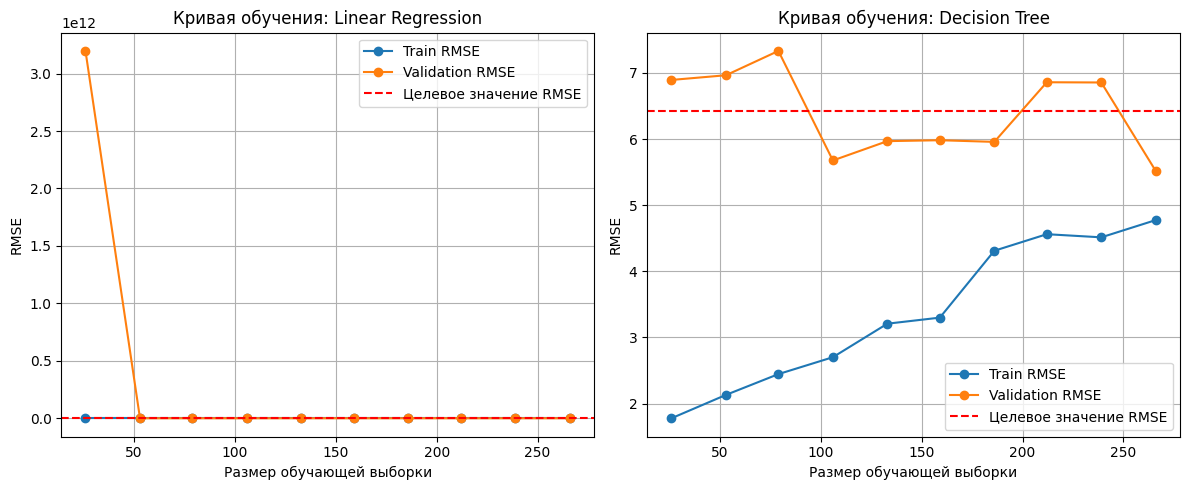

In [21]:
plt.figure(figsize=(12, 5))
for i, (name, model) in enumerate(models):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_scaled, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    val_rmse = np.sqrt(-val_scores.mean(axis=1))
    plt.subplot(1, 2, i+1)
    plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
    plt.plot(train_sizes, val_rmse, 'o-', label='Validation RMSE')
    plt.title(f'Кривая обучения: {name}')
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    # Целевое значение RMSE (например, медиана по валидации)
    target_rmse = np.median(val_rmse)
    plt.axhline(target_rmse, color='red', linestyle='--', label='Целевое значение RMSE')
    plt.legend()
plt.tight_layout()
plt.show()

Если разница между train и validation RMSE большая — модель переобучена.
Если обе ошибки высоки и близки — модель недообучена.
Linear Regression обычно менее склонна к переобучению, Decision Tree — больше.
из графиков видно тчо линейная регрессия лучше - не переоучена и не недообучена

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
models = [
    ('Linear', LinearRegression()),
    ('Ridge', Ridge(alpha=1.0)),
    ('Lasso', Lasso(alpha=0.1, max_iter=10000))
]
results = []
coefs = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    coefs.append(model.coef_)



Сравнение моделей по метрикам:
    Model      RMSE       MAE        R2
0  Linear  4.838564  3.659486  0.739865
1   Ridge  4.819978  3.641352  0.741860
2   Lasso  4.686327  3.535078  0.755977

Веса коэффициентов моделей:
              ID      crim        zn     indus      chas       nox        rm  \
Linear -0.723716 -0.515478  1.388705 -0.170802  0.991765 -1.697285  2.388400   
Ridge  -0.704607 -0.501406  1.356952 -0.208568  0.996675 -1.659773  2.403394   
Lasso  -0.400855 -0.206200  1.064858 -0.224285  0.973331 -1.353805  2.457591   

             age       dis       rad       tax   ptratio     black     lstat  
Linear -0.419825 -3.685443  3.680864 -2.246849 -1.577767  0.698334 -4.499636  
Ridge  -0.420003 -3.627601  3.519729 -2.108025 -1.566185  0.700196 -4.468358  
Lasso  -0.159243 -2.909984  2.128544 -1.175531 -1.450715  0.628105 -4.570623  


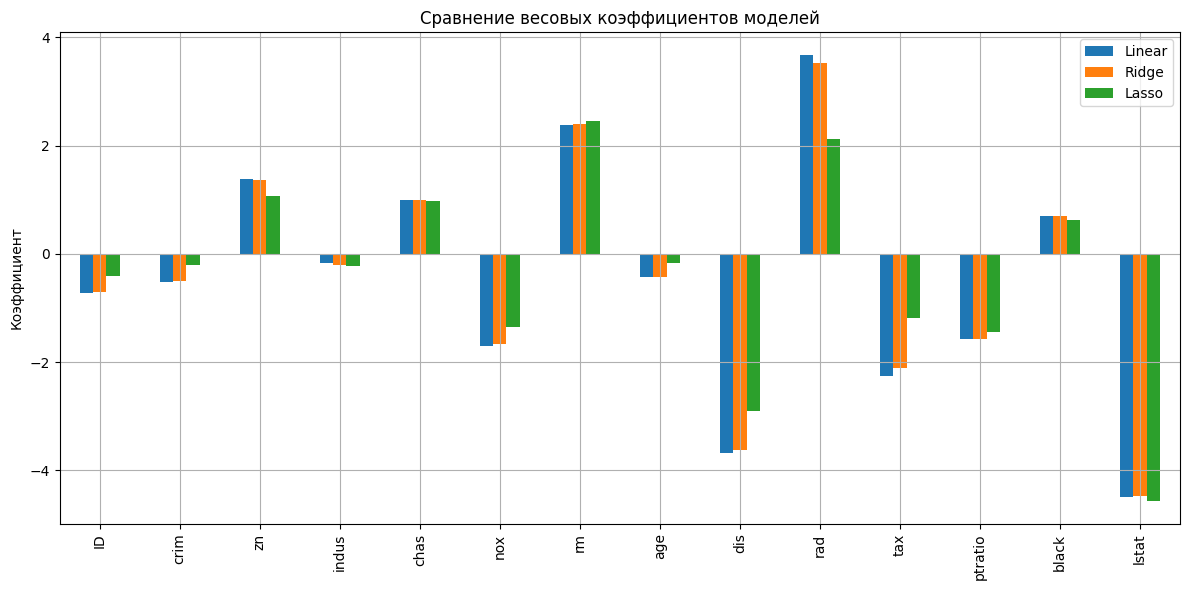

In [10]:
results_df = pd.DataFrame(results)
print('Сравнение моделей по метрикам:')
print(results_df)

coefs_df = pd.DataFrame(coefs, columns=X.columns, index=['Linear', 'Ridge', 'Lasso'])
print('Веса коэффициентов моделей:')
print(coefs_df)

coefs_df.T.plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение весовых коэффициентов моделей')
plt.ylabel('Коэффициент')
plt.grid(True)
plt.tight_layout()
plt.show()



Если веса Lasso/Ridge сильно меньше, чем у Linear — признаки коллинеарны или неинформативны.
Важные признаки имеют большие по модулю коэффициенты.
почти во всех признаках размеры весов сопоставимы, больше всех выдиляется - Rad tax dis